In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (10,6)
pd.set_option('display.max_columns', 100)
import datetime as dt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
df=pd.read_csv('recom.csv')

In [3]:
df.head()

,Unnamed: 0,Main_ID,Transaction_ID,Date,Price,Code_Product,Amount,ItemKey
0,0,90fada91,264f7a69,2022-10-07 20:53:49.153,125.0,5002.0,1.0,5002.0
1,1,9006f9ac,45c7d853,2022-09-17 15:54:57.187,19.0,35012.0,1.0,NaN
2,2,32270891,61ad76dd,2022-11-28 13:51:55.667,141.0,5005.0,1.0,5005.0
3,3,97e03e47,41ee09f6,2022-09-12 16:20:22.110,4.5,35078.5,1.0,NaN
4,4,41949228,244fe6d8,2022-10-14 18:53:43.933,129.5,49291.5,5.0,NaN


In [4]:
df['Transaction_ID'].nunique()

48403

In [5]:
df = pd.read_csv('recom.csv', usecols=lambda column: column not in ['Unnamed: 0', 'ItemKey'])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Main_ID         50000 non-null  object 
 1   Transaction_ID  50000 non-null  object 
 2   Date            50000 non-null  object 
 3   Price           50000 non-null  float64
 4   Code_Product    50000 non-null  float64
 5   Amount          50000 non-null  float64
dtypes: float64(3), object(3)
memory usage: 2.3+ MB


In [7]:
#Toplam harcamayi Column olarak ekliyoruz
df['TotalPrice']=df['Amount']*df['Price']

In [8]:
#siparis tarihinin veri tipini degistiriyoruz
df['Date']=pd.to_datetime(df['Date'])

In [9]:
# bugunu/ analiz tarihini degisken olarak atiyoruz.
today= dt.datetime(2023,1,1)
print(today)

2023-01-01 00:00:00


In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,50000.0,62.56067,68.269624,0.5,24.5,45.5,83.0,2525.5
Code_Product,50000.0,32379.29354,21697.500334,5000.5,10013.0,40009.5,49291.5,350027.5
Amount,50000.0,1.23264,0.749353,1.0,1.0,1.0,1.0,54.0
TotalPrice,50000.0,89.22196,371.822461,0.5,25.5,48.0,95.5,37026.0


In [11]:
# minimumu 0 olan deger yok.. silmeye gerek yok!

In [12]:
# Recency ve Monetary degerlerini bulalim
df_x=df.groupby('Main_ID').agg({'TotalPrice': lambda x: x.sum(),'Date':lambda x: (today-x.max()).days})

In [13]:
#Transaction_ID code halinde oldugu icin Transaction_ID'yi (Invoice) unique hale getiriyoruz.
df_y=df.groupby(['Main_ID','Transaction_ID']).agg({'TotalPrice': lambda x: x.sum()})

In [14]:
# saydirdigimizda Transaction_ID unique halde gelmis oluyor.
df_z=df.groupby('Main_ID').agg({'TotalPrice': lambda x: len(x)})

In [15]:
#RFM tablosuna ulasmis oluyoruz
rfm_table = pd.merge(df_x, df_z, on='Main_ID')


In [16]:
#column isimlerini belirliyoruz
rfm_table.rename(columns={'Date': 'Recency',
                          'TotalPrice_x':'Monetary',
                          'TotalPrice_y':'Frequency'},inplace=True)

In [17]:
rfm_table.head()

,Monetary,Recency,Frequency
Main_ID,,,
00024de6,12.0,119,1
00084856,46.0,56,2
0008e848,13.0,109,1
00096930,96.0,36,1
000c66b7,62.0,116,2


In [18]:
#Frequency bulma
def FScore(x,p,d):
    if x<=d[p][0.20]:
        return 0
    elif x<=d[p][0.40]:
        return 1
    elif x<=d[p][0.60]:
        return 2
    elif x<=d[p][0.80]:
        return 3
    else:
        return 4
    
    
quantiles= rfm_table.quantile(q=[0.20, 0.40, 0.60, 0.80])
quantiles=quantiles.to_dict()
rfm_table['Freq_Tile']=rfm_table['Frequency'].apply(FScore, args=('Frequency',quantiles))
#Recency bulma
rfm_table= rfm_table.sort_values('Recency', ascending=True)
rfm_table['Rec_Tile']=pd.qcut(rfm_table['Recency'],5,labels=False)

#Monetary bulma
# rfm_table= rfm_table.sort_values('Monetary', ascending=True)
rfm_table['Mone_Tile']=pd.qcut(rfm_table['Monetary'],5,labels=False)

# '0' degeri yer almasin istiyorsak, buldugumuz degerleri 1 artiririz
rfm_table['Rec_Tile']=rfm_table['Rec_Tile'] +1
rfm_table['Freq_Tile']=rfm_table['Freq_Tile']+1
rfm_table['Mone_Tile']=rfm_table['Mone_Tile']+1

#buldugumuz degerleri birlestirip tek 1 skor elde ediyoruz.
rfm_table['RFM Score']=rfm_table['Rec_Tile'].map(str)+rfm_table['Freq_Tile'].map(str)+rfm_table['Mone_Tile'].map(str)

rfm_table.head()



    

,Monetary,Recency,Frequency,Freq_Tile,Rec_Tile,Mone_Tile,RFM Score
Main_ID,,,,,,,
6558ca78,208.5,28,8,5,1,5,155
80851dc3,24.5,28,1,1,1,1,111
387aecb7,83.5,28,1,1,1,4,114
a70f5f11,412.0,28,4,5,1,5,155
27aa514e,2426.5,28,12,5,1,5,155


In [19]:
#degerlerin iceriklerini inceliyoruz
rfm_table.groupby('RFM Score').agg({
    'Recency': ['mean','min','max','count'],
    'Frequency':['mean','min','max','count'],
    'Monetary':['mean','min','max','count'] }).round(1).head(20)


Recency               Frequency               Monetary         \
             mean min max count      mean min max count     mean    min   
RFM Score                                                                 
111          34.0  28  40   942       1.0   1   1   942     14.7    0.5   
112          34.3  29  40   824       1.0   1   1   824     32.6   25.0   
113          34.3  29  40   682       1.0   1   1   682     52.6   41.5   
114          34.2  28  40   582       1.0   1   1   582     92.5   69.5   
115          33.9  29  40   250       1.0   1   1   250    244.8  131.0   
141          35.1  29  40    43       2.0   2   2    43     13.7    4.0   
142          34.5  29  40    79       2.0   2   2    79     33.0   26.0   
143          34.3  29  40   181       2.0   2   2   181     54.9   41.5   
144          34.2  29  40   238       2.0   2   2   238     98.0   69.5   
145          33.6  29  40   272       2.0   2   2   272    254.8  132.5   
151          32.8  29  40    12       3.1   3   4    12     13.8    3.0   
152          34.5  31  39     8       3.2   3   4     8     30.0   27.0   
153          33.9  29  40    59       3.5   3   7    59     56.9   41.5   
154          34.1  29  40   200       3.6   3  11   200     99.9   69.0   
155          33.4  28  40  1346       8.1   3  51  1346   1088.8  131.0   
211          49.3  41  57   857       1.0   1   1   857     13.4    0.5   
212          49.5  41  57  1071       1.0   1   1  1071     32.7   25.0   
213          49.3  41  57   899       1.0   1   1   899     53.7   41.5   
214          48.9  41  57   806       1.0   1   1   806     92.9   69.0   
215          48.7  41  57   346       1.0   1   1   346    245.6  131.0   

                          
               max count  
RFM Score                 
111           24.5   942  
112           41.0   824  
113           68.5   682  
114          130.5   582  
115         1494.5   250  
141           24.5    43  
142           41.0    79  
143           68.5   181  
144          130.5   238  
145         1785.0   272  
151           22.0    12  
152           36.0     8  
153           68.5    59  
154          130.5   200  
155        52634.5  1346  
211           24.5   857  
212           41.0  1071  
213           68.5   899  
214          130.5   806  
215         1860.0   346

In [20]:
rfm_table.groupby('RFM Score').size().sort_values(ascending=False)[:20]

RFM Score
511    1380
155    1346
412    1200
311    1188
411    1155
512    1150
513    1117
312    1084
212    1071
413    1070
313     985
514     947
111     942
213     899
414     858
211     857
112     824
214     806
314     801
255     752
dtype: int64

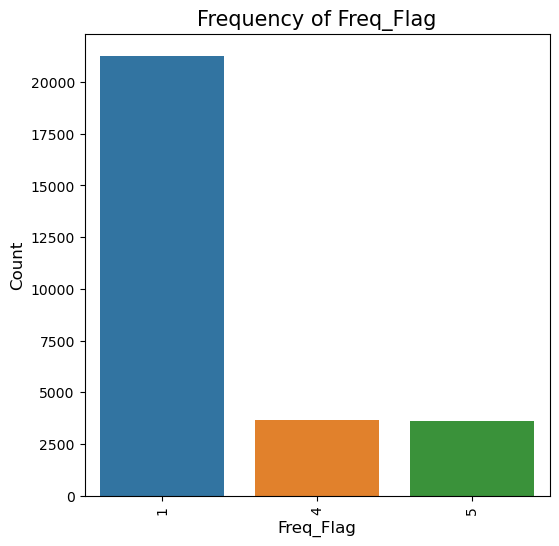

In [21]:
plt.figure(figsize=(6,6))
sns.countplot(x='Freq_Tile', data=rfm_table)
plt.ylabel('Count',fontsize=12)
plt.xlabel('Freq_Flag',fontsize=12)
plt.xticks(rotation='vertical')
plt.title('Frequency of Freq_Flag', fontsize=15)
plt.show()





C:\Users\33758\AppData\Local\Temp\ipykernel_5280\2445566121.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rfm_table['Recency'])


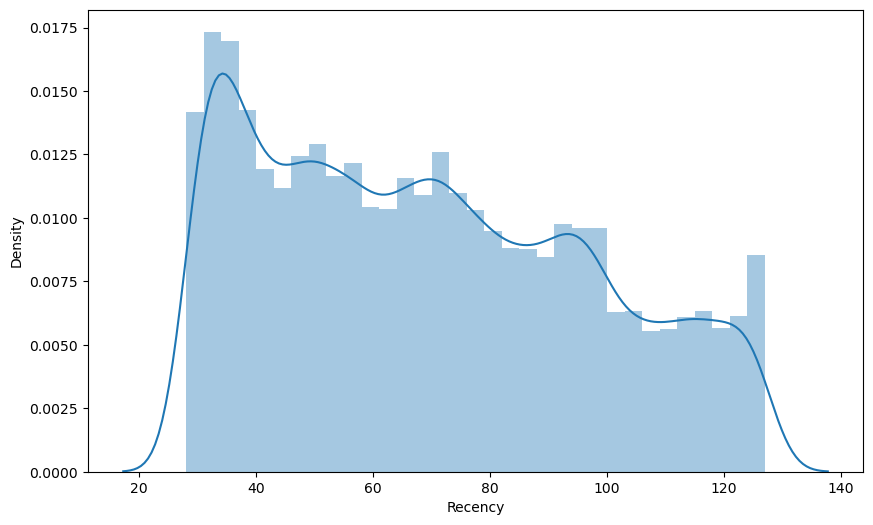

In [22]:
sns.distplot(rfm_table['Recency'])
plt.show()   

  


C:\Users\33758\AppData\Local\Temp\ipykernel_5280\2589288438.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rfm_table[rfm_table.Frequency<20]['Frequency'])


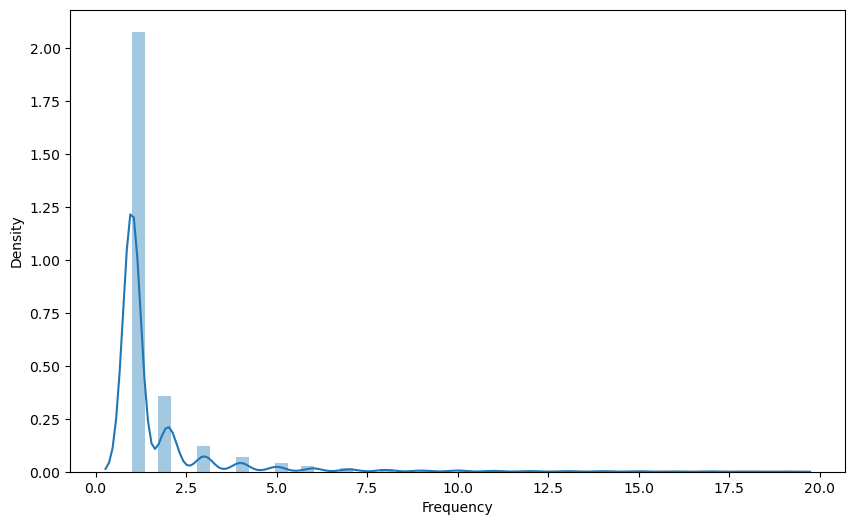

In [23]:
sns.distplot(rfm_table[rfm_table.Frequency<20]['Frequency'])
plt.show()   


C:\Users\33758\AppData\Local\Temp\ipykernel_5280\2288304250.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rfm_table['Monetary'])


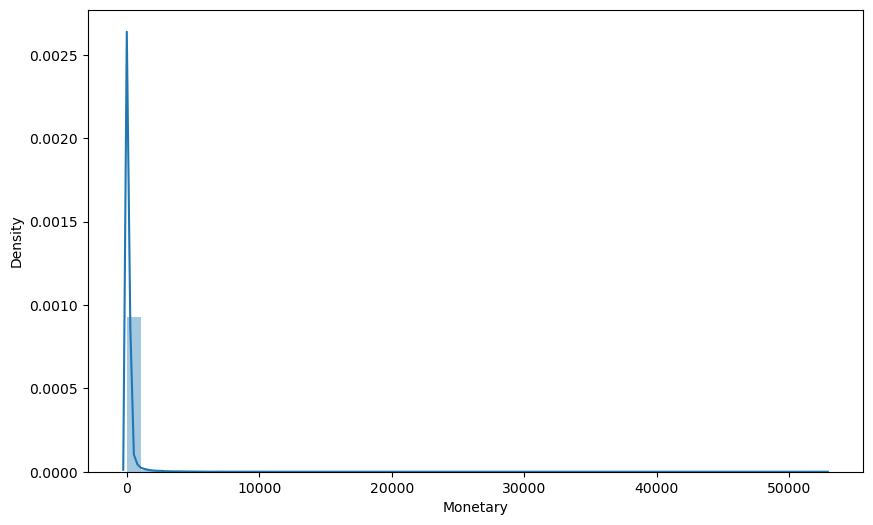

In [24]:
sns.distplot(rfm_table['Monetary'])
plt.show()   


In [25]:
rfm_table.head()

,Monetary,Recency,Frequency,Freq_Tile,Rec_Tile,Mone_Tile,RFM Score
Main_ID,,,,,,,
6558ca78,208.5,28,8,5,1,5,155
80851dc3,24.5,28,1,1,1,1,111
387aecb7,83.5,28,1,1,1,4,114
a70f5f11,412.0,28,4,5,1,5,155
27aa514e,2426.5,28,12,5,1,5,155


In [26]:
clus= rfm_table[['Monetary','Recency','Frequency']]

In [27]:
clus.head()

,Monetary,Recency,Frequency
Main_ID,,,
6558ca78,208.5,28,8
80851dc3,24.5,28,1
387aecb7,83.5,28,1
a70f5f11,412.0,28,4
27aa514e,2426.5,28,12


In [28]:
clusterdata=clus.iloc[:,0:4]
clusterdata.head()

,Monetary,Recency,Frequency
Main_ID,,,
6558ca78,208.5,28,8
80851dc3,24.5,28,1
387aecb7,83.5,28,1
a70f5f11,412.0,28,4
27aa514e,2426.5,28,12


In [29]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler= MinMaxScaler()
x_scaled=min_max_scaler.fit_transform(clus)
data_scaled2= pd.DataFrame(x_scaled)
# Virgülden sonra 4 basamak gösterme ayarı
pd.set_option('display.float_format', lambda x: '{:.4f}'.format(x))

In [30]:
data_scaled2.head()

,0,1,2
0,0.0040,0.0000,0.1400
1,0.0005,0.0000,0.0000
2,0.0016,0.0000,0.0000
3,0.0078,0.0000,0.0600
4,0.0461,0.0000,0.2200


In [31]:
# Virgülden sonra 2 basamak gösterme ayarı
pd.set_option('display.float_format', lambda x: '{:.2f}'.format(x))

In [32]:
data_scaled2.head()

,0,1,2
0,0.00,0.00,0.14
1,0.00,0.00,0.00
2,0.00,0.00,0.00
3,0.01,0.00,0.06
4,0.05,0.00,0.22


In [33]:
data_scaled2.describe().T

,count,mean,std,min,25%,50%,75%,max
0,28514.00,0.00,0.01,0.00,0.00,0.00,0.00,1.00
1,28514.00,0.42,0.28,0.00,0.17,0.38,0.64,1.00
2,28514.00,0.02,0.05,0.00,0.00,0.00,0.02,1.00


In [34]:
?KMeans

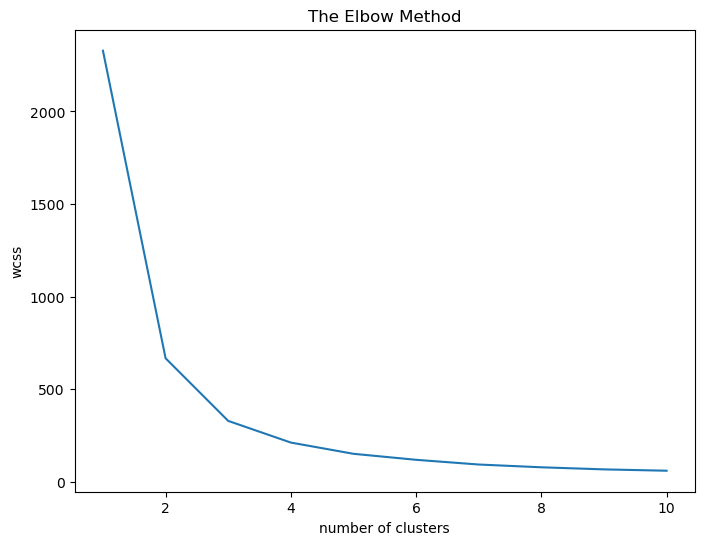

In [35]:
plt.figure(figsize=(8,6))
wcss=[]
for i in range(1,11):
    kmeans=KMeans(n_clusters=i, init='k-means++',n_init=10, max_iter=300)
    kmeans.fit(data_scaled2)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11), wcss)
plt.title('The Elbow Method')
plt.xlabel('number of clusters')
plt.ylabel('wcss')
plt.show()


In [36]:
from sklearn.metrics import silhouette_score
inertia_list=[]
silhouette_score_list=[]
for i in range (2,10):
    #kmeans=KMeans(n_clusters=i, init='k-means++',n_init=10, max_iter=300)
    kmeans.fit(data_scaled2)
    silhouette_score_list.append(silhouette_score(data_scaled2,kmeans.labels_))
    print(silhouette_score_list)
    




[0.4775757011912897]
[0.4775757011912897, 0.47233300171385767]
[0.4775757011912897, 0.47233300171385767, 0.4690989642719978]
[0.4775757011912897, 0.47233300171385767, 0.4690989642719978, 0.47280302649673245]
[0.4775757011912897, 0.47233300171385767, 0.4690989642719978, 0.47280302649673245, 0.47794810290370204]
[0.4775757011912897, 0.47233300171385767, 0.4690989642719978, 0.47280302649673245, 0.47794810290370204, 0.4689319534910398]
[0.4775757011912897, 0.47233300171385767, 0.4690989642719978, 0.47280302649673245, 0.47794810290370204, 0.4689319534910398, 0.48633518389334657]
[0.4775757011912897, 0.47233300171385767, 0.4690989642719978, 0.47280302649673245, 0.47794810290370204, 0.4689319534910398, 0.48633518389334657, 0.46888617658026016]


In [37]:
np.argmax(silhouette_score_list)+2


8

In [38]:
#kmeans using 4 clusters and k-means++ initialization
kmeans= KMeans(n_clusters=4, init='k-means++',n_init=10, max_iter=300)
kmeans.fit(data_scaled2)
pred=kmeans.predict(data_scaled2)

In [39]:
d_frame=pd.DataFrame(clus)
d_frame['cluster']=pred
d_frame['cluster'].value_counts()

0    9225
2    8319
3    6518
1    4452
Name: cluster, dtype: int64

In [40]:
d_frame.head()

,Monetary,Recency,Frequency,cluster
Main_ID,,,,
6558ca78,208.50,28,8,0
80851dc3,24.50,28,1,0
387aecb7,83.50,28,1,0
a70f5f11,412.00,28,4,0
27aa514e,2426.50,28,12,0


In [41]:
d_frame.groupby('cluster').mean()

,Monetary,Recency,Frequency
cluster,,,
0,270.08,38.45,2.59
1,92.90,114.74,1.17
2,116.40,63.48,1.51
3,90.17,88.72,1.28


## Association Rules - Birliktelik Analizi

In [42]:
!pip install mlxtend


In [43]:
!pip install mlxtend
!pip install --upgrade mlxtend
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules


In [49]:
df_apriori = df.groupby(['Transaction_ID', 'Code_Product'])['Amount'].sum().unstack().reset_index().fillna(0).set_index('Transaction_ID')


In [50]:
df_apriori.head()

Code_Product,5000.50,5001.00,5001.50,5002.00,5002.50,5003.00,5004.00,5004.50,5005.00,5007.00,5008.00,5009.00,5011.00,5011.50,5012.00,5012.50,5013.00,5015.00,5017.00,5017.50,5023.00,5024.50,5025.00,5026.00,5027.00,5027.50,10000.50,10001.00,10001.50,10002.00,10003.00,10003.50,10004.00,10006.00,10013.00,10015.00,10015.50,10021.00,10021.50,10022.00,10022.50,10023.00,10023.50,10024.00,10030.50,10031.00,10032.00,10032.50,10033.00,15000.50,...,49482.50,49483.00,49556.00,49567.50,49900.50,57035.50,60020.50,60047.50,60048.00,60048.50,60049.00,60049.50,60050.50,60051.00,60052.00,150014.50,160009.00,160009.50,160010.00,165000.50,165001.00,165016.50,165017.00,165017.50,165033.00,200002.00,200005.00,200013.50,200014.50,200016.00,200018.50,200019.00,200019.50,200020.50,200021.00,200021.50,200022.00,200025.00,200028.00,200029.00,200035.50,200037.00,200037.50,200038.00,200038.50,200045.50,200046.00,200046.50,200047.00,350027.50
Transaction_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00001871,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
0000a659,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
000683ec,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
000956f5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
000d53a0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [55]:
def num(x):
    if x<=0:
        return 0
    if x >=1:
        return 1
sepet= df_apriori.applymap(num)

In [56]:
sepet.head(10)

Code_Product,5000.50,5001.00,5001.50,5002.00,5002.50,5003.00,5004.00,5004.50,5005.00,5007.00,5008.00,5009.00,5011.00,5011.50,5012.00,5012.50,5013.00,5015.00,5017.00,5017.50,5023.00,5024.50,5025.00,5026.00,5027.00,5027.50,10000.50,10001.00,10001.50,10002.00,10003.00,10003.50,10004.00,10006.00,10013.00,10015.00,10015.50,10021.00,10021.50,10022.00,10022.50,10023.00,10023.50,10024.00,10030.50,10031.00,10032.00,10032.50,10033.00,15000.50,...,49482.50,49483.00,49556.00,49567.50,49900.50,57035.50,60020.50,60047.50,60048.00,60048.50,60049.00,60049.50,60050.50,60051.00,60052.00,150014.50,160009.00,160009.50,160010.00,165000.50,165001.00,165016.50,165017.00,165017.50,165033.00,200002.00,200005.00,200013.50,200014.50,200016.00,200018.50,200019.00,200019.50,200020.50,200021.00,200021.50,200022.00,200025.00,200028.00,200029.00,200035.50,200037.00,200037.50,200038.00,200038.50,200045.50,200046.00,200046.50,200047.00,350027.50
Transaction_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00001871,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0000a659,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
000683ec,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
000956f5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
000d53a0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
00112cdc,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
00124d38,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
00127ad7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
00146756,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [57]:
from mlxtend.frequent_patterns import fpgrowth

In [91]:
rule_fp= fpgrowth(sepet, min_support=0.0001, use_colnames=True)
rule_fp['support'] = rule_fp['support'].map('{:.4f}'.format)

rule_fp

C:\Users\33758\AppData\Roaming\Python\Python310\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
0,0.0218,(48504.5)
1,0.0126,(35000.5)
2,0.0002,(10022.0)
3,0.0099,(45002.5)
4,0.0962,(49291.5)
...,...,...
280,0.0001,"(45000.5, 45001.0)"
281,0.0001,"(10022.5, 10023.0)"
282,0.0001,"(45004.0, 10022.5)"
283,0.0001,"(45004.0, 10023.5)"


In [89]:
items= apriori(sepet, min_support=0.0001, use_colnames=True)

C:\Users\33758\AppData\Roaming\Python\Python310\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [90]:
rule = association_rules(items, metric="confidence", min_threshold=0.001)

print(rule)


   antecedents consequents  antecedent support  consequent support  support  \
0     (5000.5)    (5002.0)                0.08                0.01     0.00   
1     (5002.0)    (5000.5)                0.01                0.08     0.00   
2     (5000.5)    (5011.5)                0.08                0.02     0.00   
3     (5011.5)    (5000.5)                0.02                0.08     0.00   
4     (5000.5)   (25003.0)                0.08                0.02     0.00   
..         ...         ...                 ...                 ...      ...   
81   (49292.0)   (49291.5)                0.10                0.10     0.00   
82   (49291.5)   (49356.0)                0.10                0.02     0.00   
83   (49356.0)   (49291.5)                0.02                0.10     0.00   
84   (49356.0)   (49292.0)                0.02                0.10     0.00   
85   (49292.0)   (49356.0)                0.10                0.02     0.00   

    confidence  lift  leverage  conviction  zhangs_